In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.collection_of_experiments import CollectionOfExperiments
from helpers.plot_helpers import *
from helpers.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord, gaussian_remesh
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import hvplot
hvplot.output(widget_location='bottom')

In [2]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Feb2022/bare', additional_subfolder='output')

In [3]:
directory = "/scratch/pp2681/mom6/Apr2023/R4-sensitivity"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name)

In [4]:
directory = "/scratch/pp2681/mom6/Apr2023/R4-selected"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name)

In [5]:
#ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/generalization', additional_subfolder='output')

In [6]:
directory = "/scratch/pp2681/mom6/Apr2023/generalization"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name)

In [7]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2023/GZ21_results', additional_subfolder='')

In [8]:
len(ds.exps)

1046

In [9]:
for exp in ds.exps:
    if 'GZ' in exp:
        print(exp)

GZ21-R4
GZ21-R5
GZ21-R6
GZ21-R7
GZ21-R8
R2_GZ-20YEAR_no_scaling
R3_GZ-20YEAR_no_scaling
R4_GZ-20YEAR
R4_GZ-20YEAR_no_scaling
R5_GZ-20YEAR
R5_GZ-20YEAR_no_scaling
R6_GZ-20YEAR
R6_GZ-20YEAR_no_scaling
R7_GZ-20YEAR
R7_GZ-20YEAR_no_scaling
R8_GZ-20YEAR
R8_GZ-20YEAR_no_scaling


In [10]:
for exp in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']:
    ds.remesh('R64', exp)

Experiment R64 coarsegrained to R2 is created. Its identificator=R64_R2
Experiment R64 coarsegrained to R3 is created. Its identificator=R64_R3
Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4
Experiment R64 coarsegrained to R5 is created. Its identificator=R64_R5
Experiment R64 coarsegrained to R6 is created. Its identificator=R64_R6
Experiment R64 coarsegrained to R7 is created. Its identificator=R64_R7
Experiment R64 coarsegrained to R8 is created. Its identificator=R64_R8


# Generalization

In [11]:
def sample_ssh(exp, target):
    
    sample = []
    for year_start in [5, 10, 15]:
        year_end = year_start + 5
        idx = slice(365*year_start, 365*year_end)
        sample.append(
            Lk_error(ds[exp].ea.isel(zi=0).sel(Time=idx).mean('Time'), ds[target].ssh_mean)[0]
        )
    return xr.DataArray(sample, dims='sample')

In [12]:
def error_ssh(exp, target):
    return Lk_error(ds[exp].ssh_mean,ds[target].ssh_mean)[0]

In [13]:
def sample_KE(exp, target=None):
    sample = []
    for year_start in [5, 10, 15]:
        year_end = year_start + 5
        idx = slice(365*year_start, 365*year_end)
        u = ds[exp].u.sel(Time=idx)
        v = ds[exp].v.sel(Time=idx)
        h = ds[exp].h.sel(Time=idx)

        KE = 1e-15 * ds[exp].KE_joul(u, v, h).mean('Time').sum()
        #print(year_start)
        #print(KE.compute())
        sample.append(KE)
    return xr.DataArray(sample, dims='sample')

In [14]:
def KE(exp, target=None):
    return 1e-15 * (ds[exp].MKE_joul + ds[exp].EKE_joul).sum('zl').values

In [15]:
def sample_APE(exp, target=None):
    sample = []
    for year_start in [5, 10, 15]:
        year_end = year_start + 5
        idx = slice(365*year_start, 365*year_end)
        e = ds[exp].e.sel(Time=idx)
        APE = 1e-15 * (
            ds[exp].PE_joul(e).mean('Time').sum() + 
            ds[exp].PE_ssh(e).mean('Time').sum()
        )
        sample.append(APE)
    return xr.DataArray(sample, dims='sample')

In [16]:
def APE(exp, target=None):
    return 1e-15 * (ds[exp].MPE_joul + ds[exp].EPE_joul + ds[exp].MPE_ssh + ds[exp].EPE_ssh).values

In [17]:
def generalization_error(prefix='ZB-clean', fun=error_ssh, confs=['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8'], ZB=None):
    if ZB is None:
        ZB = sorted([float(exp.split('-')[-1]) for exp in ds.exps if f'{prefix}-R4' in exp])
    
    print(ZB)
    conf_list = []
    for i, conf in enumerate(confs):
        zb_list = []
        for j, zb in enumerate(ZB):
            try:
                error = fun(f'{prefix}-{conf}-ZB-{zb}', f'R64_{conf}')
            except:
                error = np.nan
            zb_list.append(error)
        if isinstance(zb_list[-1],xr.DataArray):
            zb_list = xr.concat(zb_list, dim='ZB')
        else:
#             import pdb
#             pdb.set_trace()
            zb_list = xr.DataArray(zb_list, dims='ZB')

        conf_list.append(zb_list)
    
    conf_list = xr.concat(conf_list, 'res')    
    conf_list['ZB'] = ZB
    return conf_list

# New plotter of APE/KE metrics

In [18]:
from matplotlib.cm import get_cmap
def plot_metric_variable_ZB(model='ZB-clean', fun=sample_KE, ZBs=None, alpha=1.0, ls='-', plot_bare=True, label=True):
    if plot_bare:
        bare = xr.concat([fun(conf,f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    
    if ZBs is None:
        if model == 'ZB-clean':
            ZBs = [0.3, 0.4, 0.5]
        elif model == 'ZB-Smooth':
            ZBs = [0.5, 1.0, 1.5]
        elif model == 'ZB-Reynolds':
            ZBs = [1.5, 2.0, 2.5]
        elif model == 'ZB-Smooth-2':
            ZBs = [0.5, 1.0, 1.5]
        elif model == 'ZB-Reynolds-2':
            ZBs = [1.5, 2.0, 2.5]
        else:
            ZBs = error.ZB
            
    error = generalization_error(model, fun=fun, ZB=ZBs)
            
    def color_function2(x):
        yellow = [0.9290, 0.6940, 0.1250]
        violet = [0.4940, 0.1840, 0.5560]
        d = {0.3: [0.16666666666666663, 0.8660254037844386, 0.8660254037844387], 
             0.4: [0.17058823529411765, 0.4946558433997788, 0.9667184042691874], 
             0.5: 'tab:blue', 1.0: yellow, 1.5: 'g', 
             2.0: violet, 2.5: 'tab:olive'}
        return d[float(x)]
    
    def marker_function(x):
        vals = [0.3, 0.4, 0.5, 1.0, 1.5, 2.0, 2.5]
        markers = ['h','*','o','p','P','d','X']
        return markers[vals.index(x)]
        
    colors = [color_function2(ZB) for ZB in ZBs]
    markers = [marker_function(ZB) for ZB in ZBs]
    
    lines = [''] * len(ZBs)

    sel = lambda x: x.mean('sample') if 'sample' in x.dims else lambda x: x
    
    for j, ZB in enumerate(ZBs):
        if isinstance(label, bool):
            _label = float(ZB) if label else None
        else:
            _label = label
        lines[j] = error.sel(ZB=ZB).mean('sample').plot(label=_label, marker=markers[j], markeredgecolor='k', markersize=6, color=colors[j], ls=ls, alpha=alpha)
        plt.fill_between(range(7), error.sel(ZB=ZB).min('sample'), error.sel(ZB=ZB).max('sample'), color=colors[j], alpha=0.2, lw=0)
    
    if plot_bare:
        bare.mean('sample').plot(color='k', marker='o')
        plt.fill_between(range(7), bare.min('sample'), bare.max('sample'), color='k', alpha=0.2, lw=0)

    plt.xticks([0,1,2,3,4,5,6], ['$1/2^{\circ}$', '$1/3^{\circ}$', '$1/4^{\circ}$', '$1/5^{\circ}$', '$1/6^{\circ}$', '$1/7^{\circ}$', '$1/8^{\circ}$'],rotation=50)
    plt.xlabel('')
    plt.title('')
    return lines

[0.3, 0.4, 0.5]
[0.3, 0.4, 0.5]
[0.3, 0.4, 0.5]
[0.5, 1.0, 1.5]
[0.5, 1.0, 1.5]
[0.5, 1.0, 1.5]
[1.5, 2.0, 2.5]
[1.5, 2.0, 2.5]
[1.5, 2.0, 2.5]


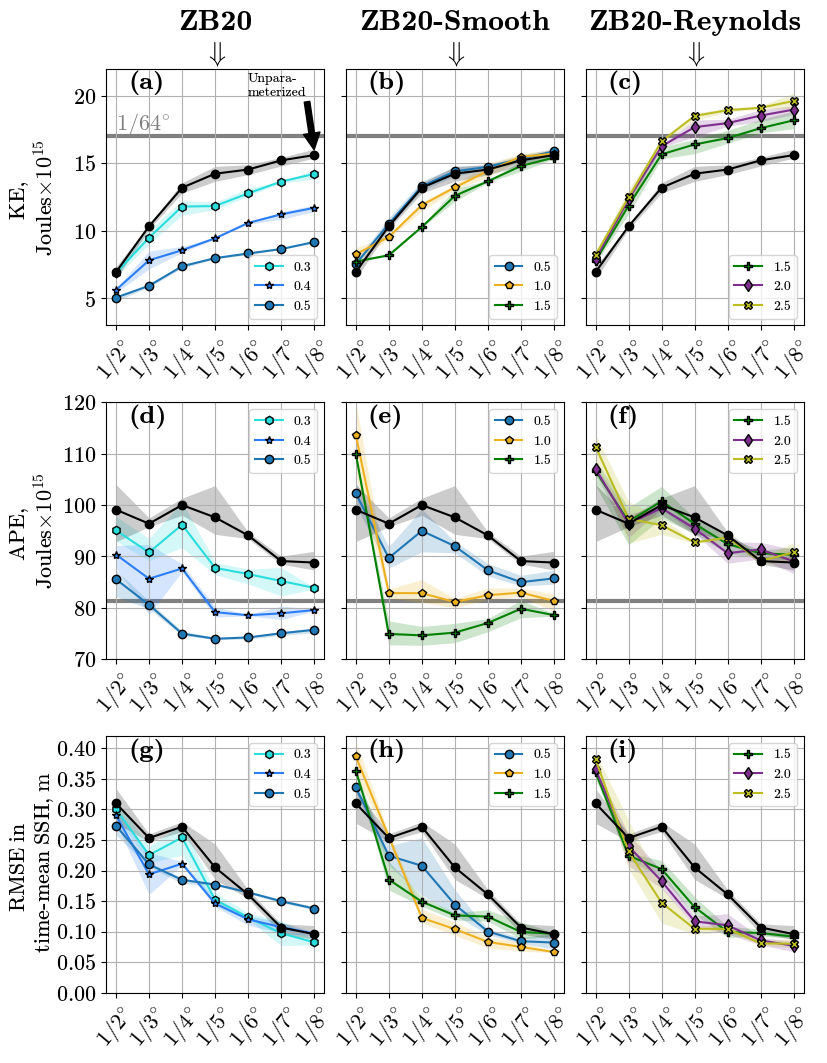

In [20]:
default_rcParams({'font.size': 16, 'figure.subplot.wspace': 0.1, 'figure.subplot.hspace': 0.3})
models = ['ZB-clean', 'ZB-Smooth', 'ZB-Reynolds']
titles = ['ZB20', 'ZB20-Smooth', 'ZB20-Reynolds']
plt.figure(figsize=(9,12))
for col in [0,1,2]:
    model = models[col]
    title = titles[col]

    plt.subplot(3,3,1 + col)
    plot_metric_variable_ZB(model=model, fun=sample_KE)
    yticks = np.arange(5,25,5)
    if col == 0:
        plt.ylabel('KE, \nJoules$\\times10^{15}$')
        plt.yticks(yticks)
    else:
        plt.yticks(yticks, [None]*len(yticks))
    plt.ylim([3,22])
    loc = 'lower right' if col<2 else 'lower right'
    plt.legend(fontsize=10,loc=loc)
    plt.grid()
    plt.axhline(y=KE('R64'),color='gray', zorder=-1,lw=3)
    if col==0:
        plt.text(0.0, 17.5,'$1/64^{\circ}$', color='gray')
        plt.gca().annotate('Unpara-\nmeterized', xy=(6, 16), xytext=(4, 20),
         arrowprops=dict(facecolor='black', shrink=0.002), fontsize=10)
    
    plt.title(title+'\n$\Downarrow$', fontweight='bold', fontsize=20)
    
    plt.subplot(3,3,4 + col)
    plot_metric_variable_ZB(model=model, fun=sample_APE)
    yticks = np.arange(70,130,10)
    if col == 0:
        plt.ylabel('APE, \nJoules$\\times10^{15}$')
        plt.yticks(yticks)
    else:
        plt.yticks(yticks, [None] * len(yticks))
    plt.ylim([min(yticks), max(yticks)])
    plt.legend(fontsize=10,loc='upper right')
    plt.grid()
    plt.axhline(y=APE('R64'),color='gray',zorder=-1,lw=3)
    
    plt.subplot(3,3,7 + col)
    plot_metric_variable_ZB(model=model, fun=sample_ssh)
    yticks = np.arange(0,0.45,0.05)
    if col == 0:
        plt.ylabel('RMSE in \n time-mean SSH, $\mathrm{m}$')
        plt.yticks(yticks)
    else:
        plt.yticks(yticks, [None]*len(yticks))
    plt.legend(fontsize=10,loc='upper right')
    plt.ylim([0,0.42])
    plt.grid()
    
plt.gcf().align_ylabels()
set_letters(fontsize=18,x=0.1,y=0.92, letters=['a','d','g','b','e','h','c','f','i'])
plt.savefig('Review/Metrics-table.pdf')

[1.0]
[1.0]
[1.0]
[1.0]
[1.0]
[1.0]
[2.0]
[2.0]
[2.0]
[2.0]
[2.0]
[2.0]


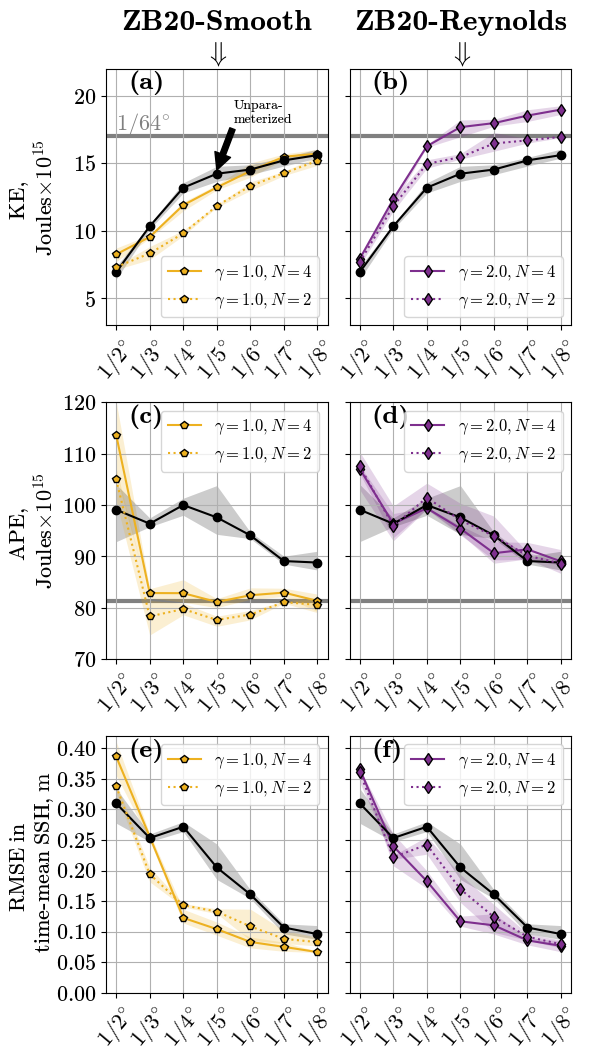

In [19]:
default_rcParams({'font.size': 16, 'figure.subplot.wspace': 0.1, 'figure.subplot.hspace': 0.3})
models = ['ZB-Smooth', 'ZB-Reynolds']
titles = ['ZB20-Smooth', 'ZB20-Reynolds']
plt.figure(figsize=(6,12))
ZBs = [[1.0], [2.0]] # plot only one line for every model
for col in [0,1]:
    model = models[col]
    title = titles[col]

    plt.subplot(3,2,1 + col)
    plot_metric_variable_ZB(model=model, fun=sample_KE, label=f'$\gamma={ZBs[col][0]}, N=4$',ZBs=ZBs[col])
    plot_metric_variable_ZB(model=model+'-2', fun=sample_KE, label=f'$\gamma={ZBs[col][0]}, N=2$',ls=':',plot_bare=False, ZBs=ZBs[col])
    yticks = np.arange(5,25,5)
    if col == 0:
        plt.ylabel('KE, \nJoules$\\times10^{15}$')
        plt.yticks(yticks)
    else:
        plt.yticks(yticks, [None]*len(yticks))
    plt.ylim([3,22])
    loc = 'lower right' if col<2 else 'lower right'
    plt.legend(fontsize=12,loc=loc)
    plt.grid()
    plt.axhline(y=KE('R64'),color='gray', zorder=-1,lw=3)
    if col==0:
        plt.text(0.0, 17.5,'$1/64^{\circ}$', color='gray')
        plt.gca().annotate('Unpara-\nmeterized', xy=(3, 14.5), xytext=(3.5, 18),
         arrowprops=dict(facecolor='black', shrink=0.002), fontsize=10)
        
    plt.title(title+'\n$\Downarrow$', fontweight='bold', fontsize=20)
    
    plt.subplot(3,2,3 + col)
    plot_metric_variable_ZB(model=model, fun=sample_APE,label=f'$\gamma={ZBs[col][0]}, N=4$',ZBs=ZBs[col])
    plot_metric_variable_ZB(model=model+'-2', fun=sample_APE, label=f'$\gamma={ZBs[col][0]}, N=2$', ls=':',plot_bare=False,ZBs=ZBs[col])
    yticks = np.arange(70,130,10)
    if col == 0:
        plt.ylabel('APE, \nJoules$\\times10^{15}$')
        plt.yticks(yticks)
    else:
        plt.yticks(yticks, [None] * len(yticks))
    plt.ylim([min(yticks), max(yticks)])
    plt.legend(fontsize=12,loc='upper right')
    plt.grid()
    plt.axhline(y=APE('R64'),color='gray',zorder=-1,lw=3)
    
    plt.subplot(3,2,5 + col)
    plot_metric_variable_ZB(model=model, fun=sample_ssh,label=f'$\gamma={ZBs[col][0]}, N=4$',ZBs=ZBs[col])
    plot_metric_variable_ZB(model=model+'-2', fun=sample_ssh, label=f'$\gamma={ZBs[col][0]}, N=2$', ls=':',plot_bare=False,ZBs=ZBs[col])
    yticks = np.arange(0,0.45,0.05)
    if col == 0:
        plt.ylabel('RMSE in \n time-mean SSH, $\mathrm{m}$')
        plt.yticks(yticks)
    else:
        plt.yticks(yticks, [None]*len(yticks))
    plt.legend(fontsize=12,loc='upper right')
    plt.ylim([0,0.42])
    plt.grid()

plt.gcf().align_ylabels()
set_letters(fontsize=18,x=0.1,y=0.92, letters=['a','c','e','b','d','f'])
plt.savefig('Review/Metrics-filters.pdf')

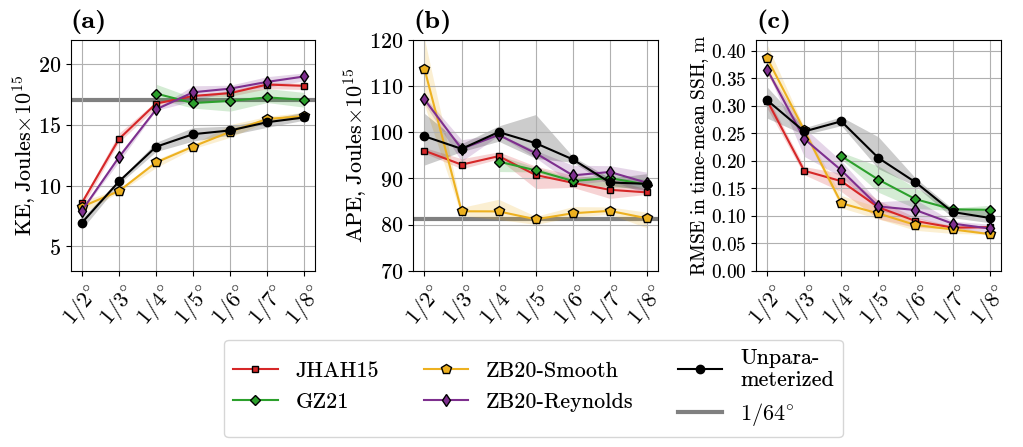

In [33]:
default_rcParams({'font.size': 16, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
plt.figure(figsize=(12,3))

yellow = [0.9290, 0.6940, 0.1250]
violet = [0.4940, 0.1840, 0.5560]
lightblue = [0.3010, 0.7450, 0.9330]

for row, fun in enumerate([sample_KE, sample_APE, sample_ssh]):
    plt.subplot(1,3,row+1)
    error = {}
    error['bare'] = xr.concat([fun(conf,f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    #error['ZB-clean'] = xr.concat([fun(f'ZB-clean-{conf}-ZB-0.4', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    error['ZB-Smooth'] = xr.concat([fun(f'ZB-Smooth-{conf}-ZB-1.0', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    error['ZB-Reynolds'] = xr.concat([fun(f'ZB-Reynolds-{conf}-ZB-2.0', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    error['Jansen-Held'] = xr.concat([fun(f'Jansen-Held-{conf}-ref', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    error['GZ'] = xr.concat([error['bare'].isel(res=0)*np.nan, error['bare'].isel(res=0)*np.nan] + [fun(f'{conf}_GZ-20YEAR', f'R64_{conf}') for conf in ['R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    
    def plot_markers_with_filling(model='Jansen-Held', color='tab:red', marker='s', label=None, markersize=None):
        error[model].mean('sample').plot(color=color, marker=marker, label=label, markersize=markersize, markeredgecolor='k')
        plt.fill_between(range(7), error[model].min('sample'), error[model].max('sample'), color=color, alpha=0.2, lw=0)
    
    plot_markers_with_filling('Jansen-Held', 'tab:red', 's', 'JHAH15', 5)
    plot_markers_with_filling('GZ', 'tab:green', 'D', 'GZ21', 5)
    #plot_markers_with_filling('ZB-clean', 'tab:blue', 'o', 'ZB')
    plot_markers_with_filling('ZB-Smooth', yellow, 'p', 'ZB20-Smooth', 7)
    plot_markers_with_filling('ZB-Reynolds', violet, 'd', 'ZB20-Reynolds', 6)
    plot_markers_with_filling('bare', 'k', 'o', 'Unpara-\nmeterized', 6)
    
    plt.xticks([0,1,2,3,4,5,6], ['$1/2^{\circ}$', '$1/3^{\circ}$', '$1/4^{\circ}$', '$1/5^{\circ}$', '$1/6^{\circ}$', '$1/7^{\circ}$', '$1/8^{\circ}$'],rotation=50)    
    plt.grid()
    plt.xlabel('')
    if fun == sample_KE:
        yticks = np.arange(5,25,5)
        plt.ylabel('KE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([3,22])
        plt.axhline(y=KE('R64'),color='gray', zorder=-1,lw=3)
        #plt.text(0.0, 17.5,'$1/64^o$', color='gray')
    if fun == sample_APE:
        yticks = np.arange(70,130,10)
        plt.ylabel('APE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([min(yticks), max(yticks)])
        plt.axhline(y=APE('R64'),color='gray',zorder=-1,lw=3)
    
    if fun == sample_ssh:
        yticks = np.arange(0,0.45,0.05)
        plt.ylabel('RMSE in time-mean SSH, $\mathrm{m}$', fontsize=14)
        plt.yticks(yticks, fontsize=14)
        plt.ylim([0,0.42])

plt.gcf().align_ylabels()
set_letters(fontsize=18,x=0.0,y=1.05)
plt.plot(np.nan,np.nan,'-',color='gray',lw=3,label='$1/64^{\circ}$')
plt.legend(ncol=3, bbox_to_anchor=(0.4,-0.25))

plt.savefig('Review/Metrics-all.pdf')